In [14]:
import torch
import sklearn.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt

In [132]:
rng = np.random.RandomState()
scale = 4.
centers = [(1, 0), (-1, 0), (0, 1), (0, -1), (1. / np.sqrt(2), 1. / np.sqrt(2)),
            (1. / np.sqrt(2), -1. / np.sqrt(2)), (-1. / np.sqrt(2),
                                                    1. / np.sqrt(2)), (-1. / np.sqrt(2), -1. / np.sqrt(2))]
centers = [(scale * x, scale * y) for x, y in centers]

dataset = []
for i in range(1000000):
    point = rng.randn(2) * 0.2
    idx = rng.randint(8)
    center = centers[idx]
    point[0] += center[0]
    point[1] += center[1]
    dataset.append(point)
dataset = np.array(dataset, dtype="float32")
dataset /= 1.414


In [171]:
def plt_samples(samples, npts=1000, title="$p(x)$"):
    _, ax = plt.subplots(figsize=(5, 5))
    ax.hist2d(samples[:, 0], samples[:, 1],  bins=npts, vmin=0, vmax=50, cmap='jet', alpha=.8)
    ax.invert_yaxis()
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(title)
    plt.show()
    return None

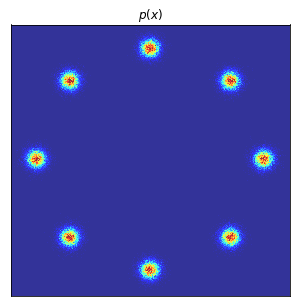

In [172]:
plt_samples(dataset)

In [102]:
dataset.shape

(1000000, 2)

In [155]:
import torch
import torch.nn as nn
from torchdiffeq import odeint_adjoint as odeint

# Define the base distribution (1D Gaussian)
def gaussian(x, mu=0, sigma=1):
    return torch.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * torch.sqrt(2 * torch.tensor(3.141592653589793)))

# Define the target distribution (bimodal)
def bimodal(x):
    return 0.5 * gaussian(x, mu=-2, sigma=0.5) + 0.5 * gaussian(x, mu=2, sigma=1)

# Define the flow model using a neural ODE
class FlowModel(nn.Module):
    def __init__(self):
        super(FlowModel, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 1)
        self.t = torch.linspace(0, 1, 10)
        
    def forward(self, t, x):
        h = torch.relu(self.fc1(x))
        h = self.fc2(h)
        return h, torch.zeros_like(h)
    
    def backward(self, z):
        with torch.no_grad():
            x = odeint(self, z, self.t, method='dopri5', rtol=1e-4, atol=1e-5)[-1]
        return x
    
# Define the loss function
def loss_fn(z, log_jacobian):
    return -torch.mean(bimodal(z) + log_jacobian)

# Define the training loop
def train_flow_model(flow_model, optimizer, epochs):
    loss_list = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        z = torch.randn(128, 1)
        x, log_jacobian = flow_model(0, z) # pass in time t=0
        loss = loss_fn(x, log_jacobian)
        loss.backward()
        optimizer.step()
        if epoch % 5 == 0:
            loss_list.append(loss.item())
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")
    return loss_list

# Instantiate the flow model and optimizer
flow_model = FlowModel()
optimizer = torch.optim.Adam(flow_model.parameters(), lr=1e-3)

# Train the flow model
loss_list = train_flow_model(flow_model, optimizer, epochs=50)

Epoch [1/50], Loss: -0.04013219103217125
Epoch [6/50], Loss: -0.048666127026081085
Epoch [11/50], Loss: -0.06019660085439682
Epoch [16/50], Loss: -0.07723675668239594
Epoch [21/50], Loss: -0.09055706858634949
Epoch [26/50], Loss: -0.10648466646671295
Epoch [31/50], Loss: -0.1222500130534172
Epoch [36/50], Loss: -0.13640323281288147
Epoch [41/50], Loss: -0.15111224353313446
Epoch [46/50], Loss: -0.1609608680009842


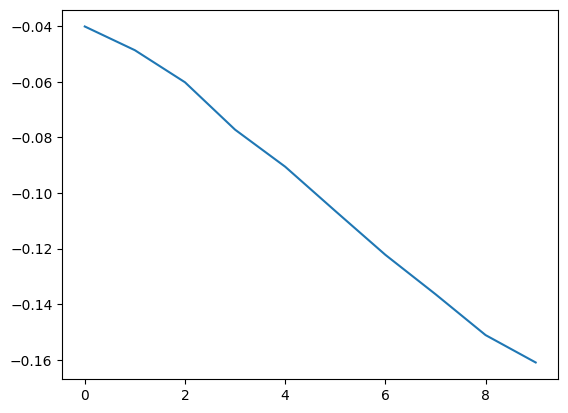

In [156]:
import matplotlib.pyplot as plt
plt.plot(loss_list)

In [157]:
flow_model.eval()
base = torch.normal(0, 1, size=(100000, 1))

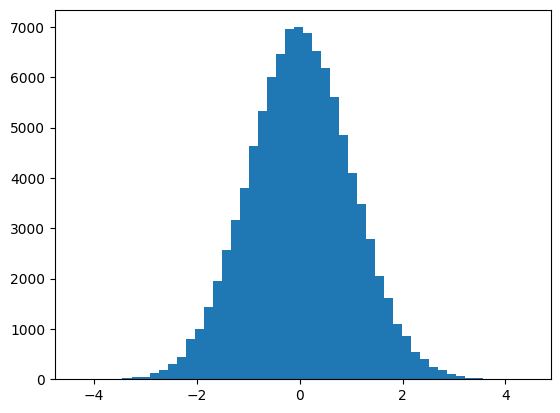

In [158]:
plt.hist(torch.squeeze(base), bins=50);

In [159]:
import numpy as np
x, _ = flow_model(0, base)
x = x.detach().numpy()

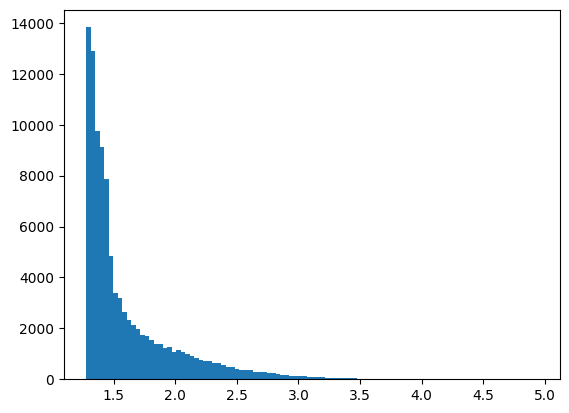

In [160]:
plt.hist(np.squeeze(x), bins=100);

In [62]:
base[0]

tensor(0.9477)

In [55]:
u

tensor([[0.8425, 0.9782, 1.0727,  ..., 1.1952, 0.9733, 1.0438]])